Stochtree Exploration
===


Based on https://stochtree.ai/python_docs/demo/supervised_learning.html

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import stochtree
from sklearn.model_selection import train_test_split

In [2]:
random_seed = 4351348959
rng = np.random.default_rng(random_seed)

# Generate covariates and basis
n = 1000
p_X = 10
p_W = 1
X = rng.uniform(0, 1, (n, p_X))
W = rng.uniform(0, 1, (n, p_W))

# Define the outcome mean function
def outcome_mean(X, W):
    return np.where(
        (X[:,0] >= 0.0) & (X[:,0] < 0.25), -7.5 * W[:,0], 
        np.where(
            (X[:,0] >= 0.25) & (X[:,0] < 0.5), -2.5 * W[:,0], 
            np.where(
                (X[:,0] >= 0.5) & (X[:,0] < 0.75), 2.5 * W[:,0], 
                7.5 * W[:,0]
            )
        )
    )

# Generate outcome
epsilon = rng.normal(0, 1, n)
y = outcome_mean(X, W) + epsilon

# Standardize outcome
y_bar = np.mean(y)
y_std = np.std(y)
resid = (y-y_bar)/y_std

In [3]:
sample_inds = np.arange(n)
train_inds, test_inds = train_test_split(sample_inds, test_size=0.5)
X_train = X[train_inds,:]
X_test = X[test_inds,:]
basis_train = W[train_inds,:]
basis_test = W[test_inds,:]
y_train = y[train_inds]
y_test = y[test_inds]

In [5]:
bart_model = stochtree.BARTModel()
bart_model.sample(X_train=X_train, y_train=y_train, basis_train=basis_train, X_test=X_test, basis_test=basis_test, num_gfr=10, num_mcmc=100)

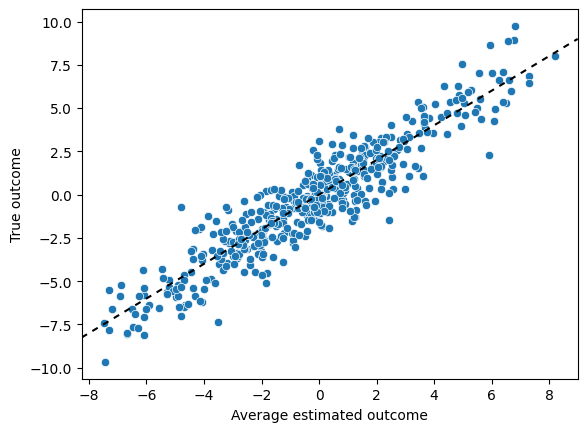

In [6]:
forest_preds_y_mcmc = bart_model.y_hat_test
y_avg_mcmc = np.squeeze(forest_preds_y_mcmc).mean(axis = 1, keepdims = True)
y_df_mcmc = pd.DataFrame(np.concatenate((np.expand_dims(y_test,1), y_avg_mcmc), axis = 1), columns=["True outcome", "Average estimated outcome"])
sns.scatterplot(data=y_df_mcmc, x="Average estimated outcome", y="True outcome")
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (3,3)))
plt.show()

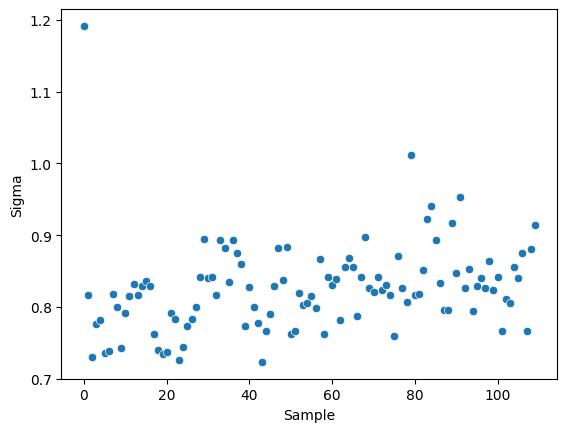

In [7]:
sigma_df_mcmc = pd.DataFrame(np.concatenate((np.expand_dims(np.arange(bart_model.num_samples),axis=1), np.expand_dims(bart_model.global_var_samples,axis=1)), axis = 1), columns=["Sample", "Sigma"])
sns.scatterplot(data=sigma_df_mcmc, x="Sample", y="Sigma")
plt.show()

In [8]:
test_rmse = np.sqrt(np.mean(np.power(y_test - np.squeeze(y_avg_mcmc),2)))
test_rmse

np.float64(1.185708569098799)